<a href="https://colab.research.google.com/github/Risha-art/MAT-422/blob/main/HW_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**2.4 Maximum Likelihood Estimation**##

####**2.4.1 MLE for Random Samples**####


Maximum likelihood estimation (MLE) is an effective approach of estimating the parameters of a probability distribution through maximizing a likelihood function. The point in the parameter space that maximizes the likelihood function is called the maximum likelihood estimate. The logic of maximum likelihood is both intuitive and flexible. As a result, the method has become a dominant means of statistical inference.

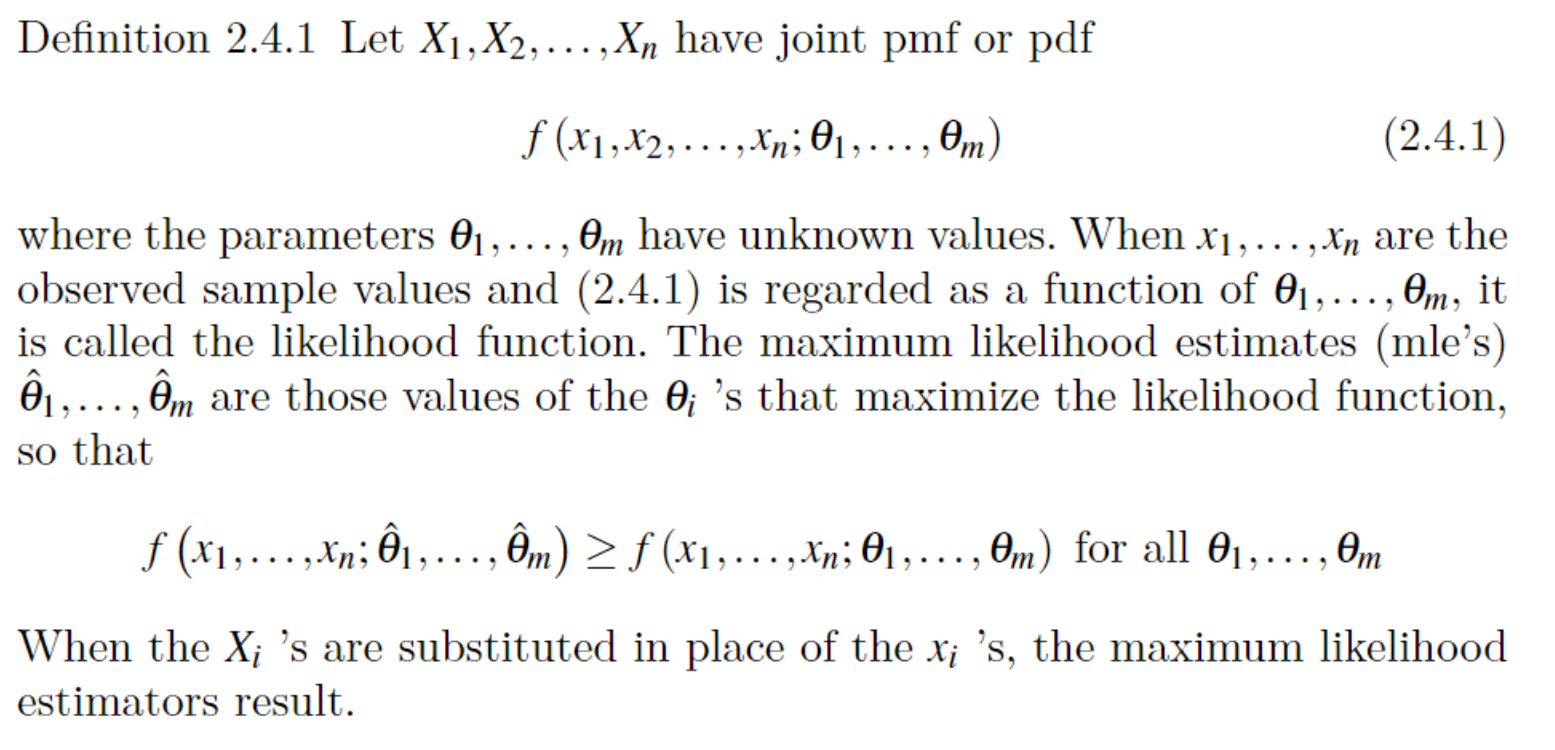



We've estimated the relationship between dependent and explanatory variables using linear regression.

But what if a linear relationship is not an appropriate assumption for our model?

One widely used alternative is maximum likelihood estimation.

The benefit relative to linear regression is that it allows more flexibility in the probabilistic relationships between variables.

Here we illustrate maximum likelihood by replicating Daniel Treisman’s (2016) paper, Russia’s Billionaires, which connects the number of billionaires in a country to its economic characteristics.

The paper concludes that Russia has a higher number of billionaires than economic factors such as market size and tax rate predict.

To explain the process in layman's terms:
Maximum Likelihood Estimation (MLE) is a way of finding the "best fit" for a statistical model based on some data we have. Imagine we have a set of measurements or observations, and we want to know which values or parameters (like the average, or variance) best explain what we see.

Here’s a simple way to think about it:

1. **Guess and Test**: Suppose we’re trying to guess the most likely characteristics of a population based on a small sample. For example, if we're studying weights, we could try different guesses of the "average weight" to see which one fits our sample data the best.

2. **Likelihood**: For each guess, we calculate how likely it is that this specific sample of data came from a population with that average weight. This likelihood is essentially a measure of how well our guess matches our actual data.

3. **Maximize the Likelihood**: MLE means we go through different guesses and find the one that gives the highest likelihood. In other words, we’re finding the parameter values (like that average weight) that make the observed data the most probable.

By maximizing this "likelihood" function, MLE gives us the parameter values that best explain or "fit" the data we’ve observed.

The paper is interested in estimating the number of billionaires in different countries.
Since the number of billionaires is integer-valued, we will only consider distributions
that are non-negative integers, like the Poisson distribution.
Plotting the Poisson distribution over y for different values of mu as follows:


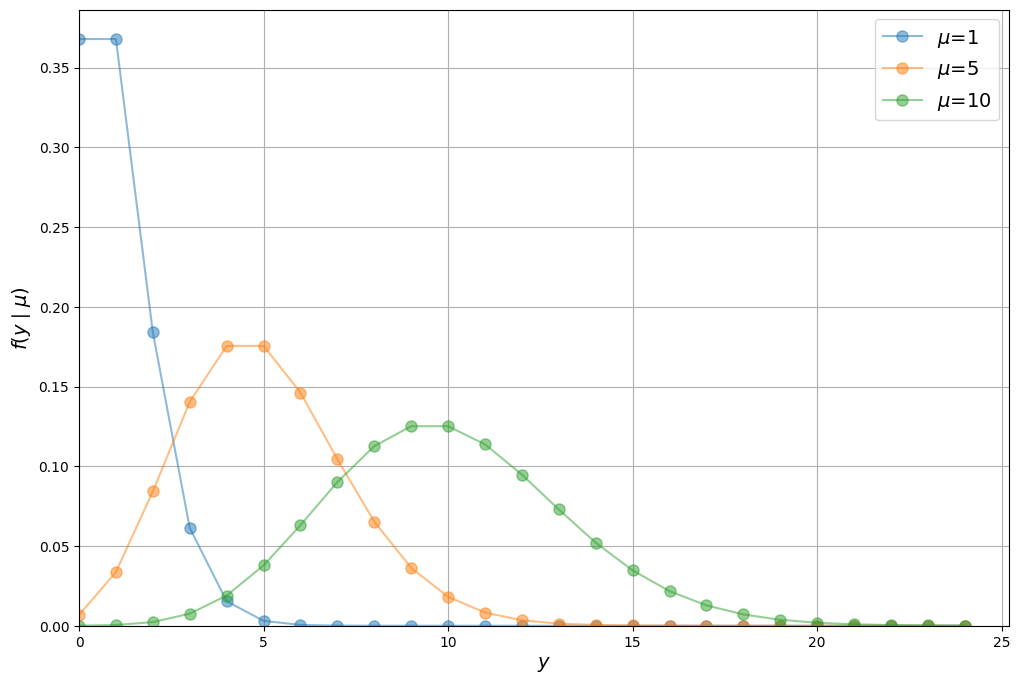

In [8]:
# require the following imports
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

print('The paper is interested in estimating the number of billionaires in different countries.')
print('Since the number of billionaires is integer-valued, we will only consider distributions')
print('that are non-negative integers, like the Poisson distribution.')
print('Plotting the Poisson distribution over y for different values of mu as follows:')

poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()


The Poisson distribution begins to resemble a normal distribution as the mean of y increases.

Treisman’s main source of data is Forbes’ annual rankings of billionaires and their estimated net worth.

The dataset mle/fp.dta can be downloaded from here or its AER page.

In [9]:
pd.options.display.max_columns = 10

# Load in data and view
df = pd.read_stata('https://github.com/QuantEcon/lecture-python/blob/master/source/_static/lecture_specific/mle/fp.dta?raw=true')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


Using a histogram, we can view the distribution of the number of billionaires per country, numbil0, in 2008 (the United States is dropped for plotting purposes)

In [ ]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

From the histogram, it appears that the Poisson assumption is not unreasonable (albeit with a very low mu and some outliers).

In our model for number of billionaires, the conditional distribution contains 4 (k=4) parameters that we need to estimate.To estimate the model using MLE, we want to maximize the likelihood that our estimate β equals the true β.

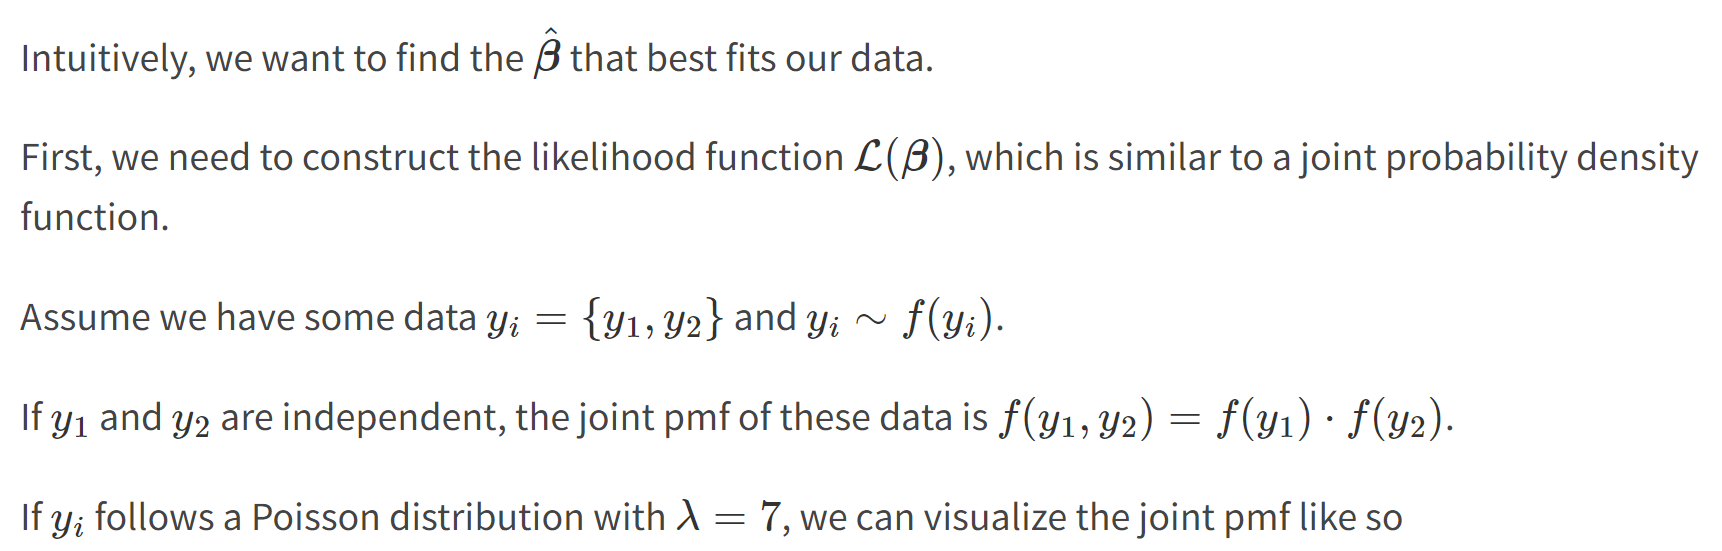

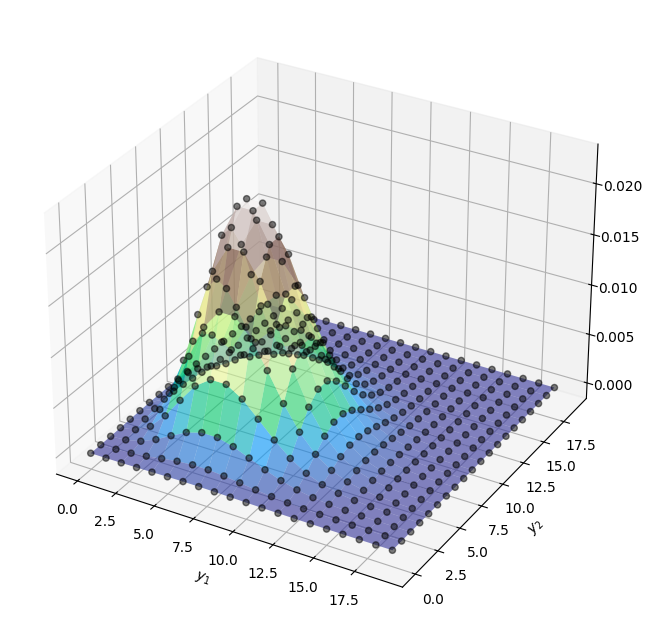

In [11]:
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)

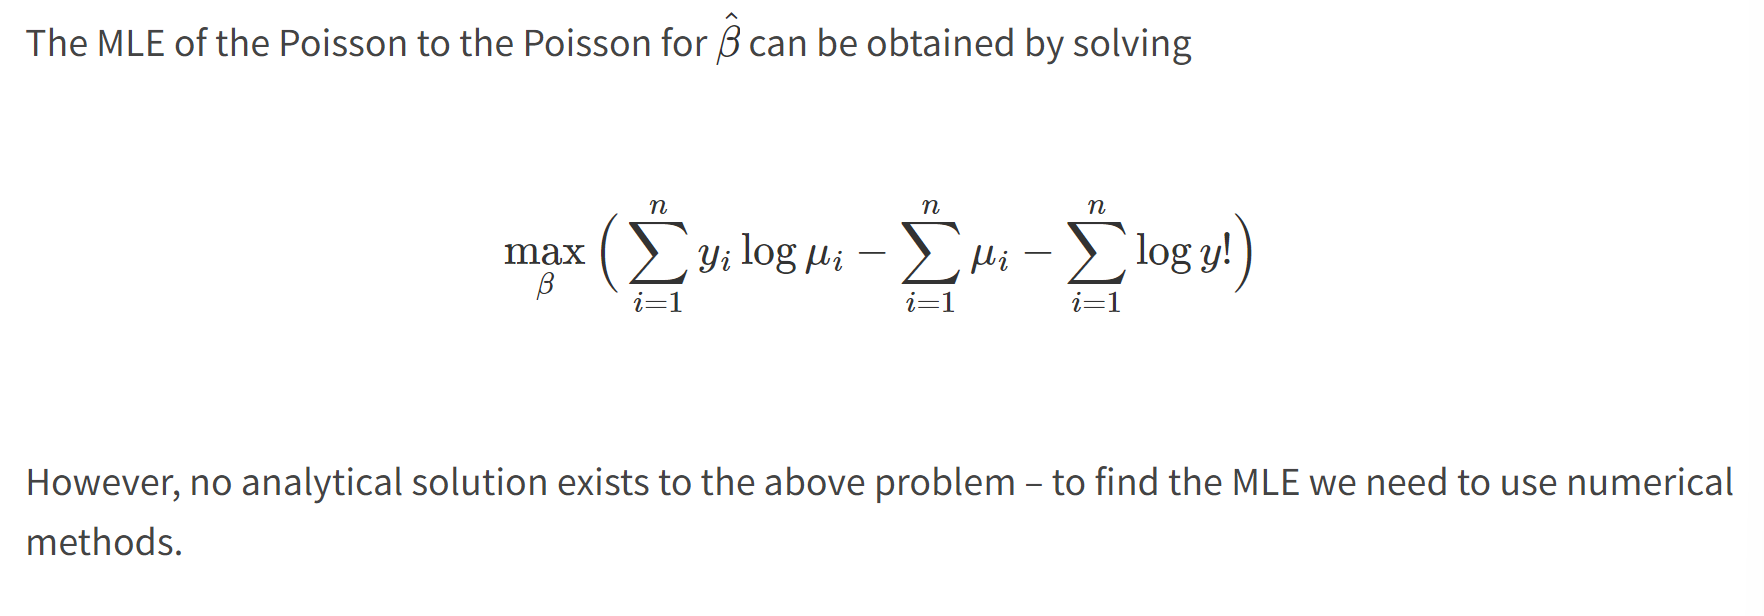

Many distributions do not have nice, analytical solutions and therefore require numerical methods to solve for parameter estimates.

One such numerical method is the Newton-Raphson algorithm.



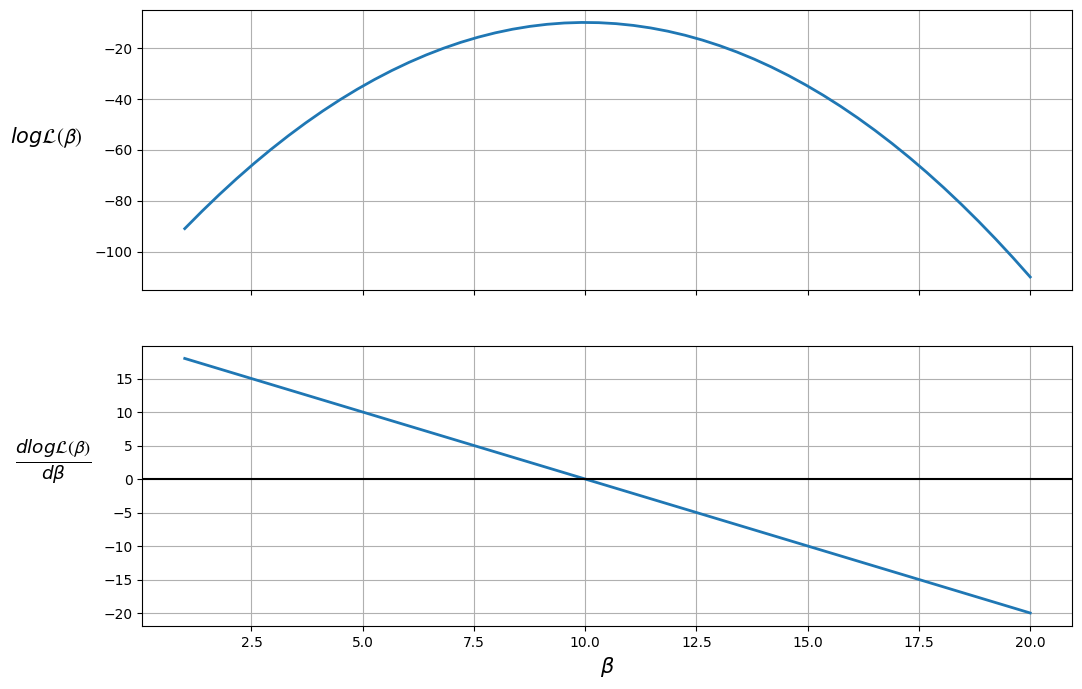

In [12]:
β = np.linspace(1, 20)
logL = -(β - 10) ** 2 - 10
dlogL = -2 * β + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL, lw=2)
ax2.plot(β, dlogL, lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

the likelihood is maximized when beta = 10.

We can also ensure that this value is a maximum (as opposed to a minimum) by checking that the second derivative (slope of the bottom plot) is negative.

The Newton-Raphson algorithm finds a point where the first derivative is 0.

The following code implements the Newton-Raphson algorithm.

First, we’ll create a class called PoissonRegression so we can easily recompute the values of the log likelihood, gradient and Hessian for every iteration

In [13]:
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        # Reshape y as a n_by_1 column vector
        self.y = y.reshape(self.n,1)
        # Reshape β as a k_by_1 column vector
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

The algorithm will update the parameter vector according to the updating rule, and recalculate the gradient and Hessian matrices at the new parameter estimates.

Iteration will end when either:

The difference between the parameter and the updated parameter is below a tolerance level.

The maximum number of iterations has been achieved (meaning convergence is not achieved).

The following utilizes the Poisson regression model in statsmodels to get a richer output with standard errors, test values, etc.

First, we re-estimate our simple model with statsmodels to obtain same coefficients and log-likelihood value.

In [17]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())


Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                  0.2546
Time:                        10:27:22   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

Now let’s replicate results from Daniel Treisman’s paper, Russia’s Billionaires, mentioned earlier in the lecture.

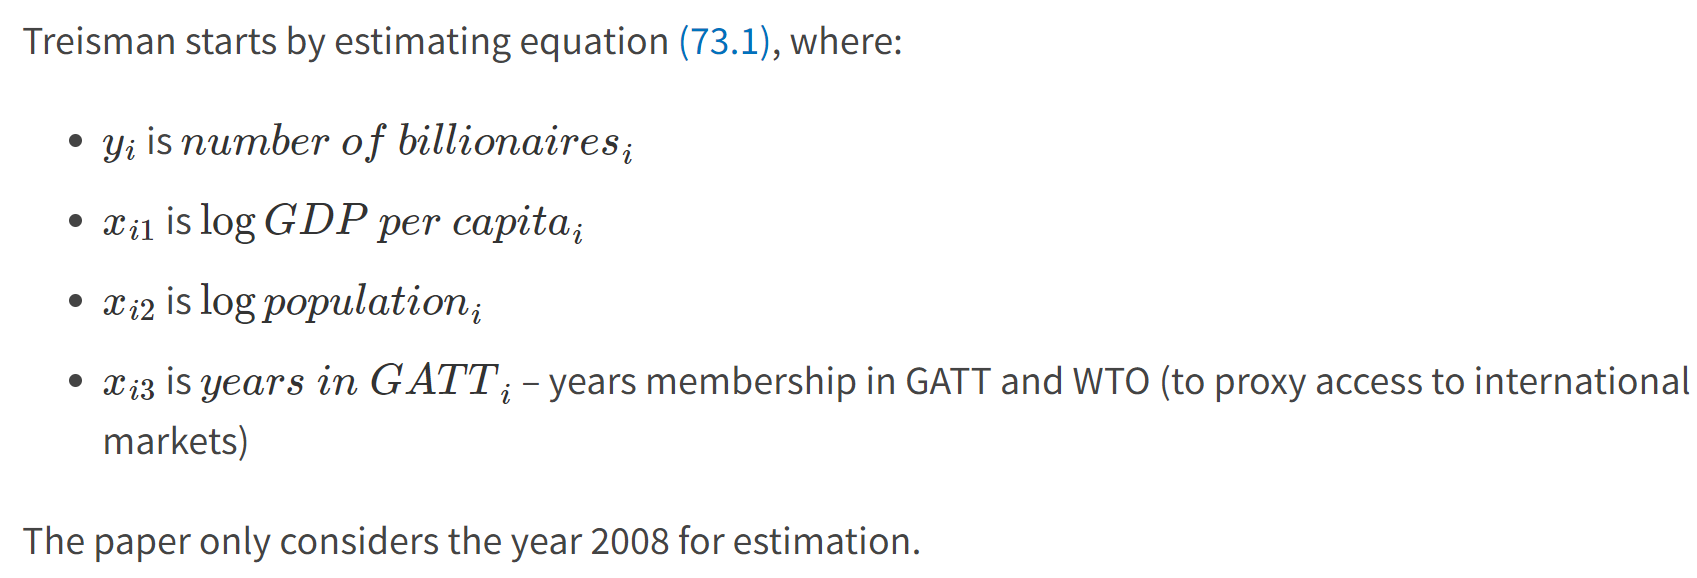

We will set up our variables for estimation like so (you should have the data assigned to df from earlier in the lecture)


In [18]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

#then we use Poisson function from statsmodels to fit the model, using robust standard errors as in paper
# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())


Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                  0.8574
Time:                        10:29:38   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

The algorithm was able to achieve convergence in 9 iterations.

Our output indicates that GDP per capita, population, and years of membership in the General Agreement on Tariffs and Trade (GATT) are positively related to the number of billionaires a country has, as expected.

Let’s also estimate the author’s more full-featured models and display them in a single table

In [19]:
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0',
                                            maxiter=100, disp=0)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires \
                        in 2008')
print(results_table)

Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw              

The output suggests that the frequency of billionaires is positively correlated with GDP per capita, population size, stock market capitalization, and negatively correlated with top marginal income tax rate.

To analyze our results by country, we can plot the difference between the predicted an actual values, then sort from highest to lowest and plot the first 15.

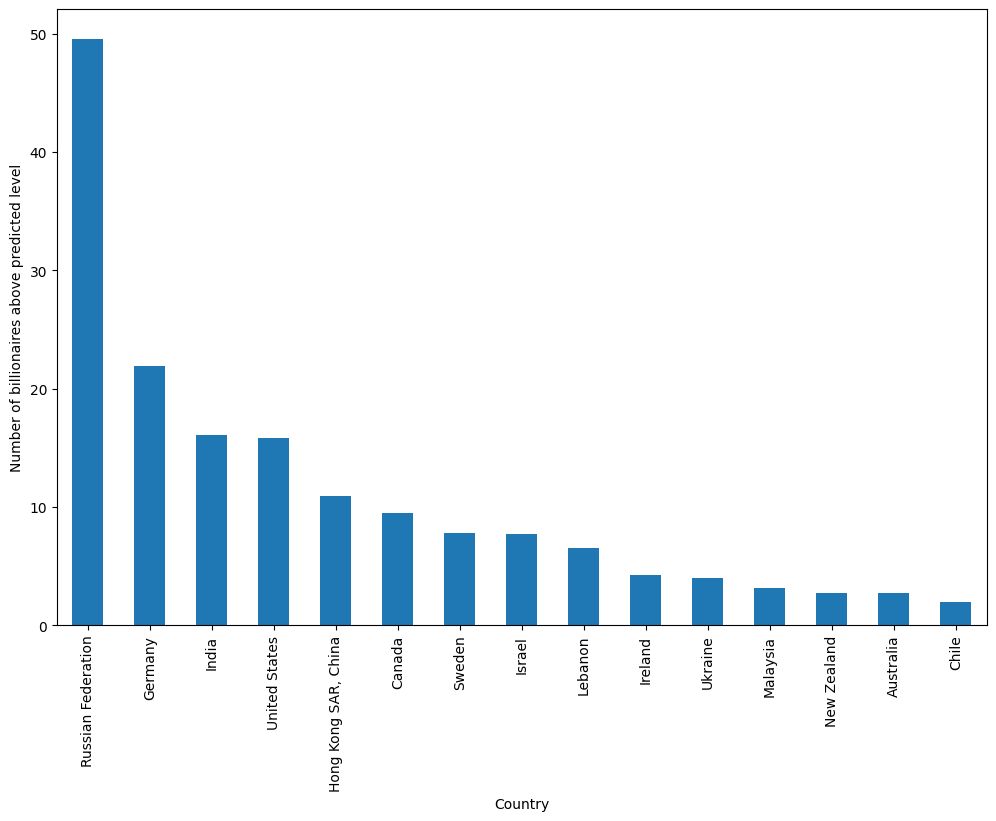

In [20]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar',
                    figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

**Conclusion**

Russia has by far the highest number of billionaires in excess of what is predicted by the model (around 50 more than expected).

Treisman uses this empirical result to discuss possible reasons for Russia’s excess of billionaires, including the origination of wealth in Russia, the political climate, and the history of privatization in the years after the USSR.

In summary, Maximum Likelihood Estimation was used to estimate the parameters of a Poisson model.

Reference: https://python.quantecon.org/mle.html

####**2.4.2 Linear Regression**####

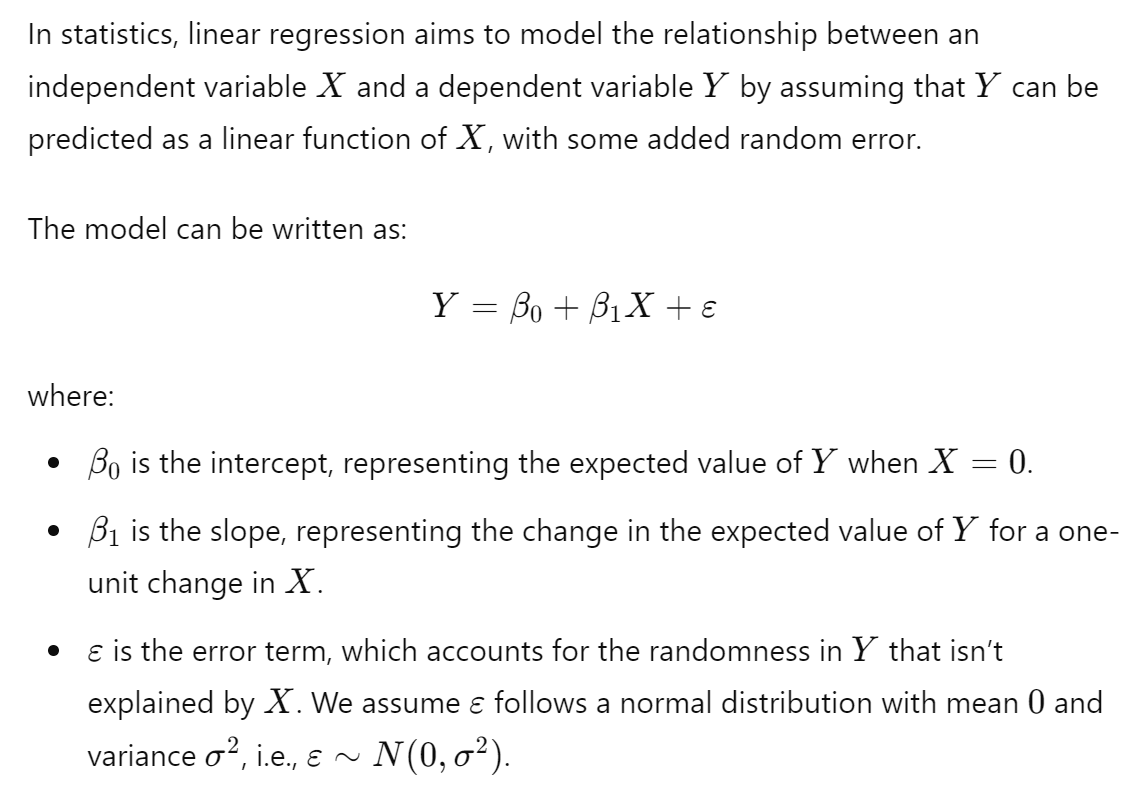

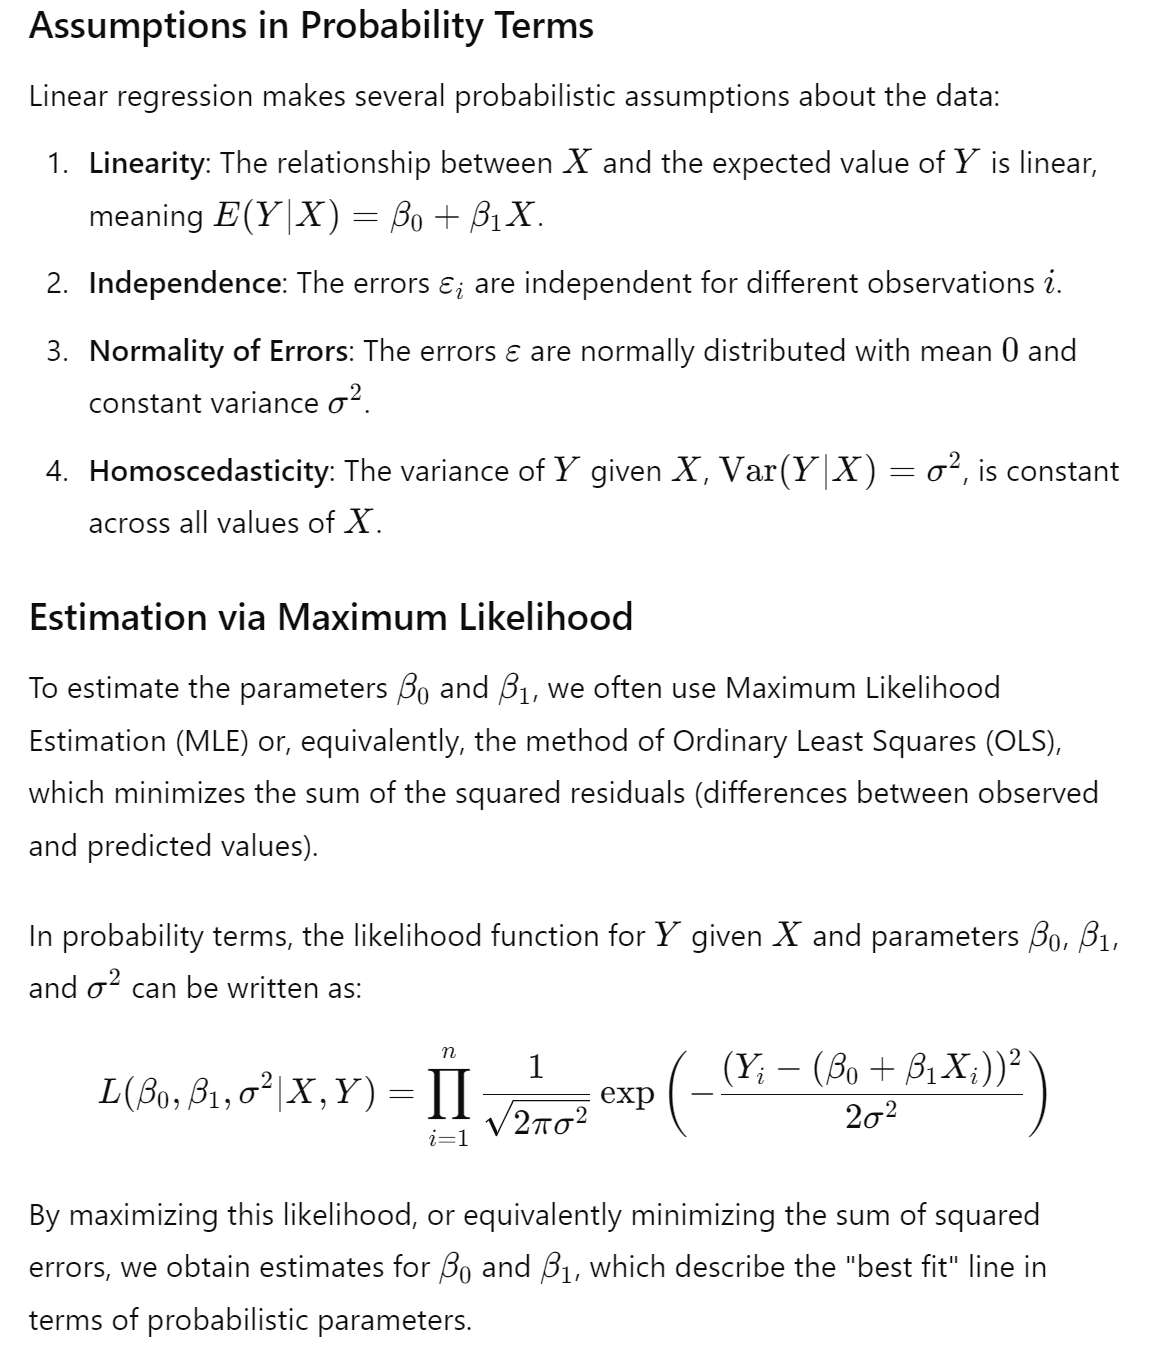